In [1]:
using ITensors
using Plots
using Measurements

In [2]:
L = 20;
N = 1;
G² = 1.5;
m = 0.4;

In [3]:
sites = siteinds("Fermion", L);
ITensors.state(::StateName"Plus", ::SiteType"Fermion") = [1/sqrt(2) 1/sqrt(2)]

In [4]:
function GrossNeveu(l)
    ampo = OpSum();
    for j in 1:l-N
        ampo -= 1im,"C",j,"Cdag",j+N
        ampo += 1im,"C",j+N,"Cdag",j
    end
    for j in 1:N:l-N
        ampo += (G²/2),"C * Cdag",j
    end
    for j in 1:l
        ampo += (m*(-1)^j),"C * Cdag",j
    end
    ψ₀ = randomMPS(sites[1:l],10)
    H = MPO(ampo, sites[1:l])
    sweep = Sweeps([
         "maxdim" "mindim" "cutoff" 
          100      2       1e-16    
          300      10      1e-16    
          700      20      1e-18    
          1000     30      1e-20    
          1024     50      1e-22
         ])
    e, ψ = dmrg(H, ψ₀, sweep)
    return e,ψ,H
end

GrossNeveu (generic function with 1 method)

In [5]:
mps_vector = Vector{MPS}()
mpo_vector = Vector{MPO}()
ovr_vector = Vector{Float64}()
for j in 2:2:L
    println("j = ",j)
    e₀, ψ₀, H = GrossNeveu(j)
    nrm = norm(inner(H,ψ₀,H,ψ₀) - inner(ψ₀',H,ψ₀)^2)
    push!(mps_vector, ψ₀)
    push!(mpo_vector, H)
    push!(ovr_vector,nrm)
end

j = 2
After sweep 1 energy=-0.625312359163 maxlinkdim=2 maxerr=0.00E+00 time=26.968
After sweep 2 energy=-0.625312451187 maxlinkdim=2 maxerr=0.00E+00 time=0.001
After sweep 3 energy=-0.625312451187 maxlinkdim=2 maxerr=0.00E+00 time=0.001
After sweep 4 energy=-0.625312451187 maxlinkdim=2 maxerr=0.00E+00 time=0.001
After sweep 5 energy=-0.625312451187 maxlinkdim=2 maxerr=0.00E+00 time=0.025
j = 4
After sweep 1 energy=-1.129623387940 maxlinkdim=4 maxerr=0.00E+00 time=25.038
After sweep 2 energy=-1.173074147171 maxlinkdim=4 maxerr=0.00E+00 time=0.004
After sweep 3 energy=-1.175029904835 maxlinkdim=4 maxerr=0.00E+00 time=0.003
After sweep 4 energy=-1.175096451009 maxlinkdim=4 maxerr=0.00E+00 time=0.003
After sweep 5 energy=-1.175098692496 maxlinkdim=4 maxerr=0.00E+00 time=0.005
j = 6
After sweep 1 energy=-1.820901897265 maxlinkdim=8 maxerr=0.00E+00 time=0.005
After sweep 2 energy=-1.828435470870 maxlinkdim=8 maxerr=0.00E+00 time=0.008
After sweep 3 energy=-1.829812745970 maxlinkdim=8 maxerr

In [6]:
for j in 1:length(mps_vector)
    println(inds(mps_vector[j][end-1])[1])
end

(dim=2|id=636|"Fermion,Site,n=1")
(dim=2|id=282|"Fermion,Site,n=3")
(dim=2|id=16|"Fermion,Site,n=5")
(dim=2|id=978|"Fermion,Site,n=7")
(dim=2|id=864|"Fermion,Site,n=9")
(dim=2|id=561|"Fermion,Site,n=11")
(dim=2|id=166|"Fermion,Site,n=13")
(dim=2|id=395|"Fermion,Site,n=15")
(dim=2|id=406|"Fermion,Site,n=17")
(dim=2|id=324|"Fermion,Site,n=19")


In [7]:
function OverLap(ψ₁::MPS, ψ₂::MPS)
    len₁ = length(ψ₁)
    len₂ = length(ψ₂)  # larger lattice
    v = ITensor(1.0)
#     v1 = state(inds(ψ₂[len₂-1])[1], "Plus")
    v2 = state(inds(ψ₂[len₂])[1], "Plus")
    for j in 1:len₁
        v = v*dag(ψ₁[j])*ψ₂[j]
    end
    v = v*dag(v1)*ψ₂[len₂-1]
    v = v*dag(v2)*ψ₂[len₂]
    return inner(v,v), norm(v)
end

OverLap (generic function with 1 method)

In [8]:
ol_inner = Vector{Float64}()
ol_norm = Vector{Float64}()
for j in 1:(length(mps_vector)-1)
    inn, nrm = OverLap(mps_vector[j],mps_vector[j+1])
    push!(ol_inner, inn)
    push!(ol_norm, nrm)
end

In [9]:
err = [sqrt(x) for x in ovr_vector[1:end-1]];
print(length(err))
minimum(err), maximum(err)

9

(7.450617676733326e-9, 0.008671767409672279)

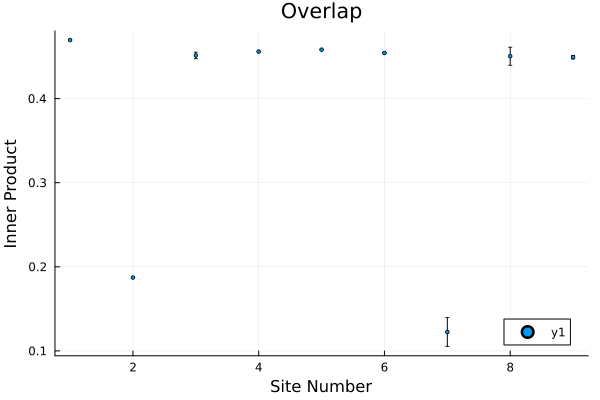

In [18]:
x = [x for x in 1:length(ol_norm)]
scatter(x,ol_norm .±err*2,
#     xlim=(-1,40),xticks=((1:2:40)), 
#     ylim=(0.1,0.9), 
    #yticks=((0.4:0.01:0.5)),   
    markersize=2,
    xlabel="Site Number",
    ylabel="Inner Product",
    title="Overlap")
#savefig("one_norm_err.svg")

In [13]:
ol_inner

9-element Vector{Float64}:
 0.22055074901937316
 0.03506062760683576
 0.20369077676560032
 0.20788131806556806
 0.20997440155223446
 0.20637547039480128
 0.01499645422072041
 0.2028659691990447
 0.20183441870706673